In [1]:
#combine files 
import glob 
import os
#clean 
import string
import pandas as pd
import numpy as np
import emoji
import nltk
import re 
from cleantext import clean
#sleep timer 
import time 
import logging
import threading
#show most common words
from collections import Counter
#word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('paxel_id.csv')
column_titles = ['rating','caption']
df1 = df.reindex(columns=column_titles)
df1 = df1.dropna()

In [3]:
df1['middle'] = df1['caption'].str.split(")").str[1] 
df1['reviews'] = df1['middle'].str.split("(").str[0]

df1 = df1.reset_index()

In [4]:
df1['reviews'].fillna('0', inplace = True)
for i, row in df1.iterrows(): 
    review = row['reviews']
    if review == '0':
        df1['reviews'][i] = review.replace('0', row['caption'])

/var/folders/5w/0kxl7gbj5vqb93sccvkxwrzc0000gn/T/ipykernel_53913/1854476216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews'][i] = review.replace('0', row['caption'])


### Clean the data

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and lemmatize/stem.'''
    text = str(text).lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = clean(text, no_emoji=True)
    text = emoji.demojize(text, delimiters=("", "")) #change emoji into text 
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round1))
df1

,index,rating,caption,middle,reviews
0,0,1.0,JASA PAKET ANEH DAN GA ADA ATTDNYA. KALO SUDAH...,NaN,jasa paket aneh dan ga ada attdnya kalo sudah ...
1,1,5.0,(Translated by Google) Thank God I had a good ...,Thank God I had a good experience with Paxel....,thank god good experience paxel time flat rate...
2,2,1.0,(Translated by Google) 3 x sending with frozen...,3 x sending with frozen food facilities but a...,x sending frozen food facilities arriving dest...
3,3,1.0,(Translated by Google) Items are lost on the w...,"Items are lost on the way, what kind of couri...",items lost way kind courier trustworthy work r...
4,4,1.0,(Translated by Google) My package receipt numb...,My package receipt number TPXL-0000000FJRV is...,package receipt number missing sent wrong cour...
...,...,...,...,...,...
387,550,5.0,After experiences with so many of the other co...,NaN,experiences many courier services available lo...
388,554,5.0,(Translated by Google) It's cool (Original) K...,It's cool (Original,cool
389,555,5.0,(Translated by Google) Cool concept of sending...,Cool concept of sending the items ... really ...,cool concept sending items really cheap jabode...
390,560,5.0,Fast Same-Day delivery service & Real-time update,NaN,fast sameday delivery service realtime update


### Sentiment analysis 


In [6]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
def clean_text_round2(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round2))

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    if sentiment_dict['compound'] >= 0.05 : 
       return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
       return "Neutral"
        
df1['sentiment'] = pd.DataFrame(df1['reviews'].apply(sentiment_scores))

In [8]:
column_titles = ['rating','reviews','sentiment']
df1 = df1.reindex(columns=column_titles)
df1.to_csv('paxel_Greviews.csv')

In [9]:
df_neg = df1.drop(df1[df1['sentiment'] != 'Negative'].index)
df_neg

,rating,reviews,sentiment
4,1.0,package receipt number missing sent wrong cour...,Negative
6,1.0,customer service never give solution first shi...,Negative
17,1.0,bad expedition said service frozen product tri...,Negative
18,1.0,customer service chat wa also bot chat dont nu...,Negative
19,1.0,minus star package went stale ordered frozen f...,Negative
...,...,...,...
343,2.0,paxels courier picked shipment duren tiga unpr...,Negative
345,1.0,difficult contact complaining,Negative
350,1.0,bona fide courier service said one day service...,Negative
356,1.0,disappointing see big mango area today want ac...,Negative


In [10]:
#combining the text into one long string for word cloud 
cloud_string = df_neg['reviews'].str.cat(sep=' ')

In [11]:
# Let's first pull out the top 30 words for each category
words = []
for word in cloud_string.split():
        words.append(word)
Counter(words).most_common()

[('...', 136),
 ('service', 79),
 ('package', 65),
 ('bad', 51),
 ('day', 44),
 ('customer', 42),
 ('paxel', 35),
 ('food', 30),
 ('courier', 26),
 ('arrived', 26),
 ('c', 25),
 ('time', 25),
 ('even', 24),
 ('wa', 23),
 ('delivery', 19),
 ('though', 19),
 ('really', 19),
 ('hour', 17),
 ('arrive', 17),
 ('sent', 15),
 ('dont', 15),
 ('number', 14),
 ('said', 14),
 ('call', 14),
 ('disappointed', 14),
 ('phone', 14),
 ('complaint', 14),
 ('pick', 14),
 ('frozen', 13),
 ('use', 13),
 ('using', 13),
 ('item', 13),
 ('doesnt', 12),
 ('contacted', 12),
 ('contact', 12),
 ('hasnt', 12),
 ('status', 12),
 ('want', 11),
 ('give', 11),
 ('send', 11),
 ('still', 11),
 ('one', 11),
 ('order', 11),
 ('didnt', 11),
 ('first', 10),
 ('also', 10),
 ('lost', 10),
 ('via', 10),
 ('picked', 10),
 ('difficult', 10),
 ('good', 10),
 ('expedition', 9),
 ('answer', 9),
 ('center', 9),
 ('morning', 9),
 ('pickup', 9),
 ('long', 9),
 ('disappointing', 9),
 ('pm', 9),
 ('shipment', 8),
 ('complain', 8),
 ('ch

In [12]:
#add meaningless words to stopwords
add_stop_words = ['...' , 'call', 'dont', 'cant']
stop_words = add_stop_words + stop 

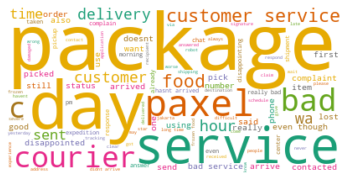

In [13]:
#wordcloud for top 100 words 
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, max_words = 100)

wordcloud = wc.generate(cloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

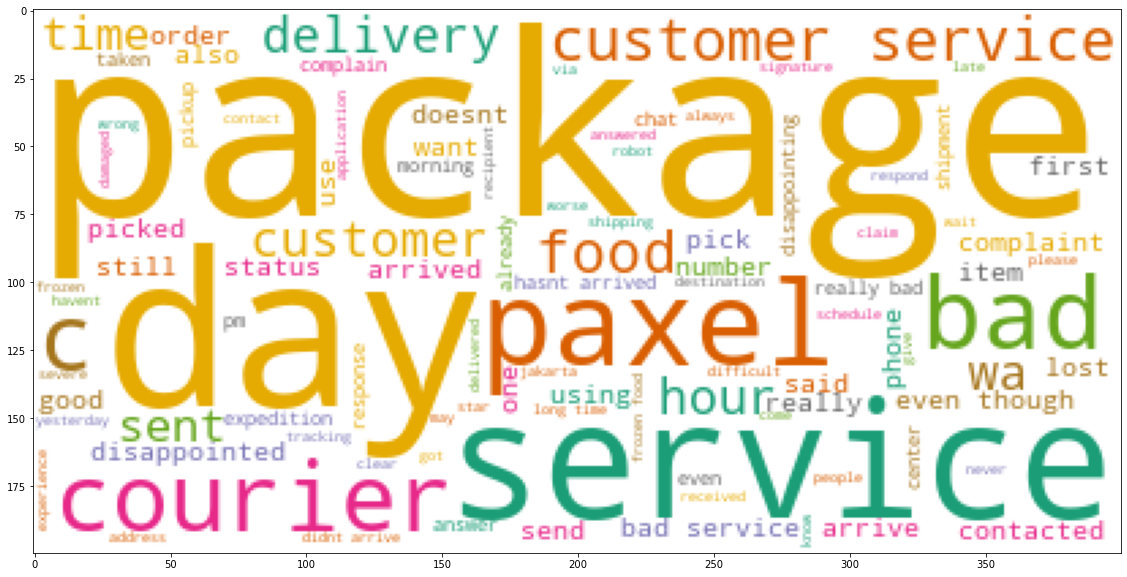

In [14]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)

In [15]:
late_words = ['slow', 'late', 'long']
df_late = df_neg[df_neg['reviews'].str.contains('|'.join(late_words))]
df_late = df_late.rename(columns ={'reviews':'Late reviews'})

In [16]:
df_late

,rating,Late reviews,sentiment
40,1.0,application clearcs doesnt helpthe bot answere...,Negative
48,1.0,contact contacted package late lost c via wa e...,Negative
55,1.0,really bad morning pickup set canceled unilate...,Negative
56,1.0,c package late hour still delivered although p...,Negative
67,1.0,severe super duper bad professionalnot timeno ...,Negative
73,1.0,bad service can not contect call center respon...,Negative
92,1.0,delivery schedule customer service can not rea...,Negative
95,1.0,late send package professional give confirmati...,Negative
132,1.0,package swapped crazy already clear address ev...,Negative
137,1.0,disappointing package arrived day late day eve...,Negative


In [17]:
df_late.to_csv('Late_reviews_paxel.csv')